# Introducing Brain MRI Segmentation Utilizing the UNet Architecture

##### Automated segmentation of brain Magnetic Resonance Imaging (MRI) scans plays a crucial role in diagnosing and treating neurological disorders. Among the numerous architectures developed, the UNet architecture has gained significant recognition for its exceptional performance. The UNet model, introduced by Ronneberger et al. in 2015, excels in segmenting complex brain structures by capturing fine-grained details while retaining high-level context. This study aims to explore and implement the UNet architecture for brain MRI segmentation, leveraging its potential to improve accuracy and efficiency. By utilizing curated datasets and advanced training techniques, precise segmentation results can be achieved, contributing to enhanced diagnostics and research applications in neuroimaging.

### Importing Libraries

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


### Importing Dataset

In [177]:
im_width = 256
im_height = 256

image_filename_train = [] #non-mask files

mask_files = glob(pathname='.\lgg-mri-segmentation\kaggle_3m\*\*_mask*')
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))
print(image_filename_train[:1])
len(image_filename_train)

['.\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif']


3929

In [179]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize  = (12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

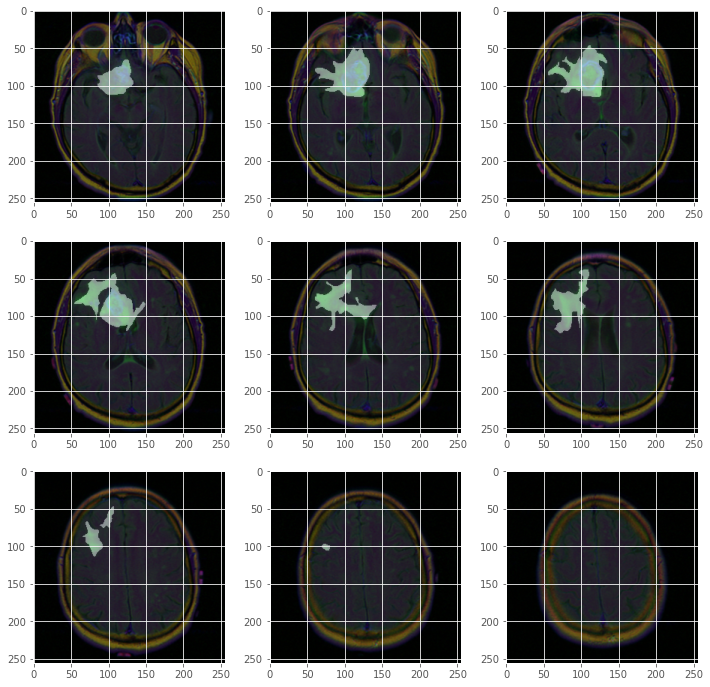

In [119]:
plot_from_img_path(3, 3, image_filename_train, mask_files)

### Preprocessing the Data

In [120]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.15)

In [121]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2671, 2)
(472, 2)
(786, 2)


In [122]:
print(len(df_train))

2671


In [123]:
df_train.head()

,image_filename_train,mask
2515,.\lgg-mri-segmentation\kaggle_3m\TCGA_FG_6691_...,.\lgg-mri-segmentation\kaggle_3m\TCGA_FG_6691_...
3665,.\lgg-mri-segmentation\kaggle_3m\TCGA_HT_8114_...,.\lgg-mri-segmentation\kaggle_3m\TCGA_HT_8114_...
2403,.\lgg-mri-segmentation\kaggle_3m\TCGA_FG_6689_...,.\lgg-mri-segmentation\kaggle_3m\TCGA_FG_6689_...
425,.\lgg-mri-segmentation\kaggle_3m\TCGA_DU_5851_...,.\lgg-mri-segmentation\kaggle_3m\TCGA_DU_5851_...
2978,.\lgg-mri-segmentation\kaggle_3m\TCGA_HT_7602_...,.\lgg-mri-segmentation\kaggle_3m\TCGA_HT_7602_...


In [124]:
import os

# Check training data
for index, row in df_train.iterrows():
    if not os.path.exists(row['image_filename_train']):
        print(f"Missing image: {row['image_filename_train']}")
    if not os.path.exists(row['mask']):
        print(f"Missing mask: {row['mask']}")

# Check validation data
for index, row in df_val.iterrows():
    if not os.path.exists(row['image_filename_train']):
        print(f"Missing image: {row['image_filename_train']}")
    if not os.path.exists(row['mask']):
        print(f"Missing mask: {row['mask']}")

In [163]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

def dice_coeff(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coeff_loss(y_true, y_pred, smooth=100):
    return -dice_coeff(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

In [164]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )
    # print(f"Images found: {image_generator.samples}")
    # print(f"Masks found: {mask_generator.samples}")
    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

### UNet Architecture

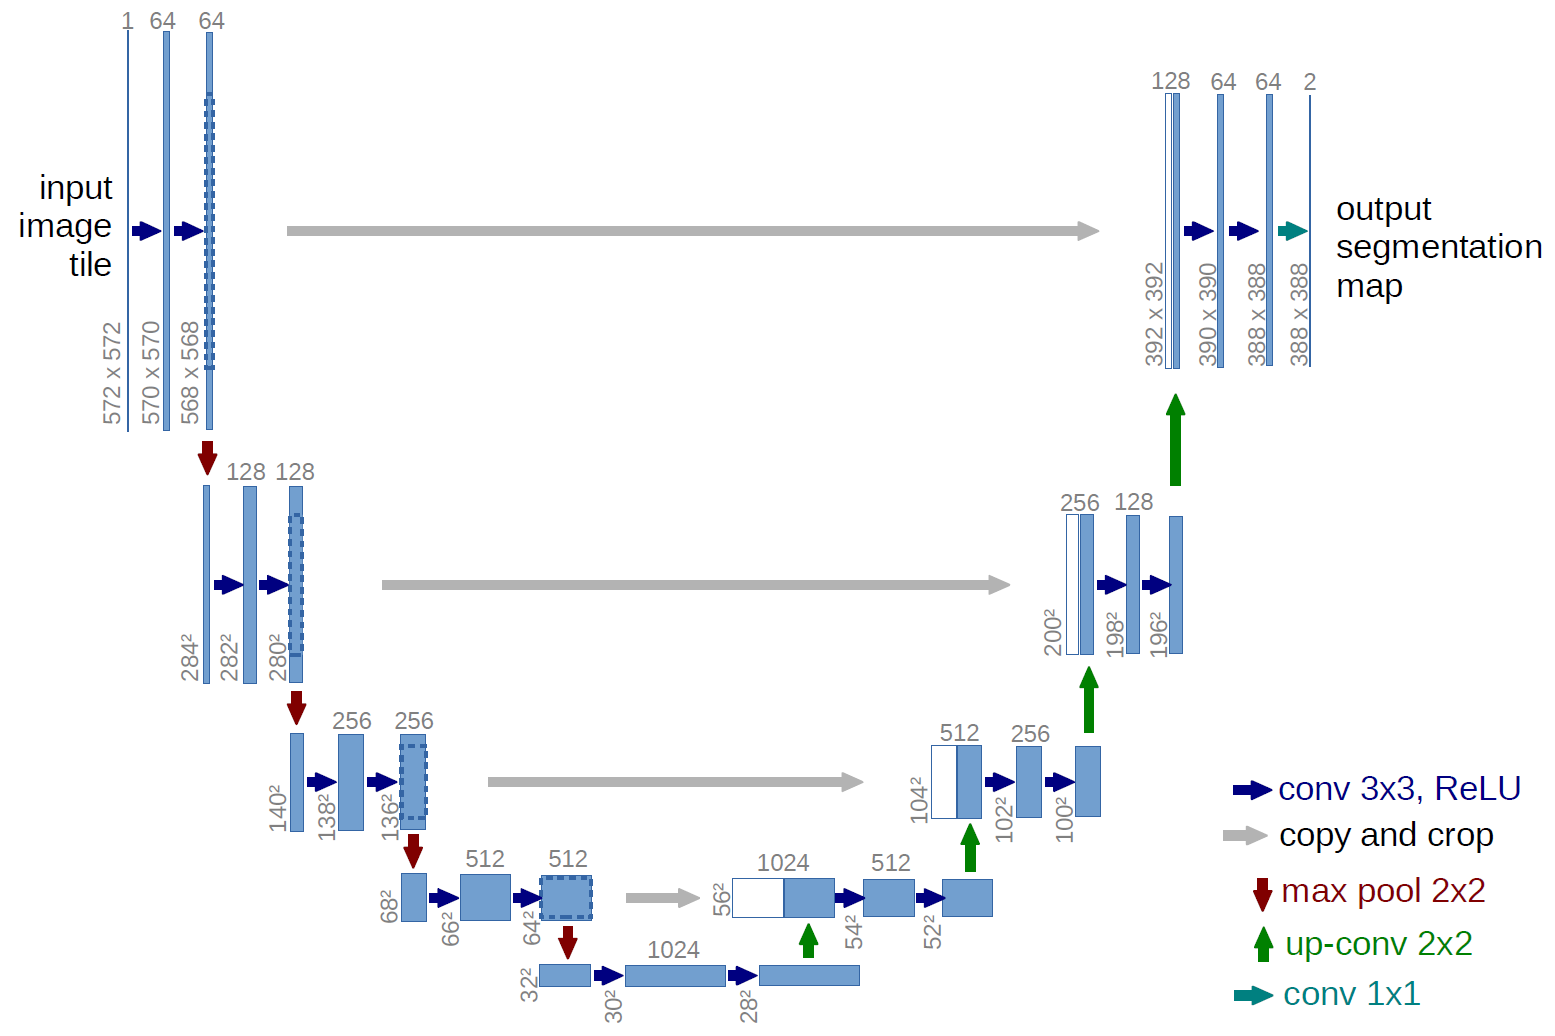

In [166]:
display(Image(filename='Unet_Architecture.png'))

In [167]:
def unet(input_size=(im_width, im_height, 3)):
    
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    # First DownSampling
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    #Second DownSampling
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    # Third DownSampling
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1],axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [168]:
model = unet()
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_457 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_25[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_432      │ (None, 256, 256,  │          0 │ conv2d_457[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_458 (Conv2D) │ (None, 256, 256,  │     36,928 │ activation_432[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_458[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_433      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_96    │ (None, 128, 128,  │          0 │ activation_433[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_459 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_96… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_434      │ (None, 128, 128,  │          0 │ conv2d_459[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_460 (Conv2D) │ (None, 128, 128,  │    147,584 │ activation_434[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_460[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_435      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_97    │ (None, 64, 64,    │          0 │ activation_435[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_461 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_97… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_436      │ (None, 64, 64,    │          0 │ conv2d_461[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_462 (Conv2D) │ (None, 64, 64,    │    590,080 │ activation_436[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_462[0][0]

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

### Training the UNet model

In [172]:
EPOCHS = 1
BATCH_SIZE = 2
lr = 1e-4
decay_rate = lr / EPOCHS
opt = Adam(learning_rate = lr, beta_1=0.9, beta_2=0.999, decay=decay_rate, amsgrad=False)

In [188]:
print(len(df_train) / BATCH_SIZE)
print(len(df_val) / BATCH_SIZE)

1335.5
236.0


In [173]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(256, 256))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                             dict(),
                             target_size=(256, 256))
    
model = unet(input_size=(256, 256, 3))

model.compile(optimizer=opt, 
              loss=dice_coeff_loss, 
              metrics=["binary_accuracy", iou, dice_coeff])

callbacks = [ModelCheckpoint('Brain_MRI_Model.keras', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=round(len(df_train) / BATCH_SIZE), 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=round(len(df_val) / BATCH_SIZE))

Found 2671 validated image filenames.
Found 2671 validated image filenames.
Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
   1/1336 ━━━━━━━━━━━━━━━━━━━━ 13:41:23 37s/step - binary_accuracy: 0.4463 - dice_coeff: 0.0704 - iou: 0.0372 - loss: -0.0704Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
   2/1336 ━━━━━━━━━━━━━━━━━━━━ 2:07:28 6s/step - binary_accuracy: 0.4515 - dice_coeff: 0.0532 - iou: 0.0282 - loss: -0.0532  Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
   3/1336 ━━━━━━━━━━━━━━━━━━━━ 1:56:31 5s/step - binary_accuracy: 0.4587 - dice_coeff: 0.0436 - iou: 0.0233 - loss: -0.0436Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
   4/1336 ━━━━━━━━━━━━━━━━━━━━ 1:48:50 5s/step - binary_accuracy: 0.4668 - dice_coeff: 0.0374 - iou: 0.0201 - loss: -0.0374Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
   5/1336 ━━━━━━━━━━━━━━━━━━━━ 1:45:18 5s/step - binary_accuracy: 0.

KeyboardInterrupt: 

In [174]:
img_batch, mask_batch = next(train_gen)
print("Image batch shape:", img_batch.shape)
print("Mask batch shape:", mask_batch.shape)

Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
Image batch shape: (2, 256, 256, 3)
Mask batch shape: (2, 256, 256, 1)


### Plotting the metrics

In [175]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

NameError: name 'history' is not defined

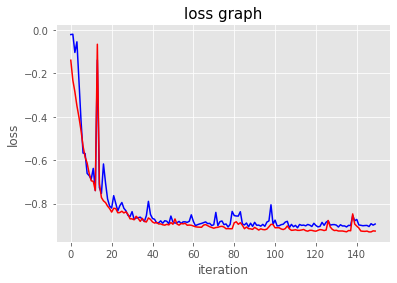

In [ ]:
display(Image(filename='Loss Graph.png'))

### Evaluating the Model

In [185]:
model = load_model('Brain_MRI_Model.keras', custom_objects={'dice_coef_loss': dice_coeff_loss, 'iou': iou, 'dice_coef': dice_coeff})

TypeError: Could not locate function 'dice_coeff_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dice_coeff_loss', 'registered_name': 'function'}

In [187]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = len(df_test)//BATCH_SIZE)
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

Found 786 validated image filenames.
Found 786 validated image filenames.
Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
  1/393 ━━━━━━━━━━━━━━━━━━━━ 37:00 6s/step - binary_accuracy: 0.8530 - dice_coeff: 0.0620 - iou: 0.0327 - loss: -0.0620Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
  2/393 ━━━━━━━━━━━━━━━━━━━━ 16:52 3s/step - binary_accuracy: 0.8556 - dice_coeff: 0.0684 - iou: 0.0362 - loss: -0.0684Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
  3/393 ━━━━━━━━━━━━━━━━━━━━ 15:14 2s/step - binary_accuracy: 0.8459 - dice_coeff: 0.0711 - iou: 0.0376 - loss: -0.0711Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)
  4/393 ━━━━━━━━━━━━━━━━━━━━ 13:45 2s/step - binary_accuracy: 0.8407 - dice_coeff: 0.0691 - iou: 0.0366 - loss: -0.0691Image shape: (2, 256, 256, 3), Mask shape: (2, 256, 256, 1)


KeyboardInterrupt: 

### Moment of Truth

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()

In [183]:
!kaggle kernels output snehashish007/notebookec7de5459d -p /Brain-MRI-Segmentation-main

Kernel log downloaded to /Brain-MRI-Segmentation-main\notebookec7de5459d.log 
